Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [119]:
from random import random, seed
from itertools import product
import numpy as np

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [120]:
UNIVERSE_SIZE = None
NUM_SETS = None
DENSITY = None
rng = None

def generate_universe(universe_size, num_sets, density):
    global UNIVERSE_SIZE, NUM_SETS, DENSITY, rng
    
    UNIVERSE_SIZE = universe_size
    NUM_SETS = num_sets
    DENSITY = density

    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [121]:
SETS = None
COSTS = None

def generate_instance():
    global SETS, COSTS
    # DON'T EDIT THESE LINES!
    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [122]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [123]:
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import accumulate

## Tweak
I use a single mutation tweak, which performs better than the multiple mutation one. I keep track of the number of sets in which each element is contained, and do not allow to go back to an invalid solution

In [124]:
def single_mutation(solution, elements):
    new_solution = solution.copy()
    index = np.random.randint(0, NUM_SETS)

    new_solution[index] = not new_solution[index]

    diff = 2*new_solution[index] - 1

    if COSTS[index] <=1:
        return solution

    if diff==-1 and np.sum(elements[SETS[index]]<=1) > 0:
        return solution
    
    elements += diff*SETS[index]

    return new_solution

def multiple_mutations(solution, elements, strength: float = 0.3): # single mutation performs better
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[rng.random.randint(NUM_SETS)] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

tweak=single_mutation

## Fitness
I maximize `(coverage,-cost)`, to make computation faster I use a support array

In [125]:
def num_elements(solution): # this solution is computationally expensive, so I did not use it in the final code
    x =np.logical_or.reduce(SETS[solution])
    return x.sum()

def fitness(solution, elements):
    return (np.sum(elements>0), -cost(solution))

## Hill climber
Starting from a random solution, I try to maximize the fitness.

I keep track of the coverage in an array to make computation faster.

In [126]:
def find_solution(MAX_STEPS):
    start_solution = rng.random(NUM_SETS) < 0.5
    solution = start_solution
    elements = SETS[solution].sum(axis=0)
    solution_fitness = fitness(solution, elements)
    history = [solution_fitness]

    ic(fitness(solution,elements), valid(solution))
    prev_elements = elements.copy()

    for n in tqdm(range(MAX_STEPS)):
        new_solution = tweak(solution, elements)
        f= fitness(new_solution, elements)
        history.append(f)
        if f > solution_fitness:
            solution = new_solution
            solution_fitness = fitness(solution,elements)
        else:
            elements = prev_elements
        prev_elements = elements.copy()
    ic(fitness(solution,elements), valid(solution))
    return solution, history

In [127]:
def plot_solution(history):
    fitness_0 = [f[0] for f in history]
    first_valid_index = next(i for i, v in enumerate(fitness_0) if v == UNIVERSE_SIZE)
    fitness_1 = [f[1] for f in history]

    plt.figure(figsize=(14, 8))
    plt.plot(
        range(first_valid_index),
        list(accumulate(fitness_1[:first_valid_index], min)),
        color="red",
        linestyle="--"
    )
    plt.plot(
        range(first_valid_index, len(fitness_1)),
        list(accumulate(fitness_1[first_valid_index:], max)),
        color="red",
    )

    plt.scatter(range(len(fitness_1)), fitness_1, marker=".")

    plt.title(f"UNIVERSE_SIZE={UNIVERSE_SIZE}, NUM_SETS={NUM_SETS}, DENSITY={DENSITY}")
    plt.show()

# Solution

ic| UNIVERSE_SIZE: 100, NUM_SETS: 10, DENSITY: 0.2, MAX_STEPS: 100
ic| fitness(solution,elements): (np.int64(76), np.float64(-155.98860081547943))
    valid(solution): np.False_
100%|██████████| 100/100 [00:00<00:00, 9879.64it/s]
ic| fitness(solution,elements): (np.int64(100), np.float64(-315.10776829403585))
    valid(solution): np.True_


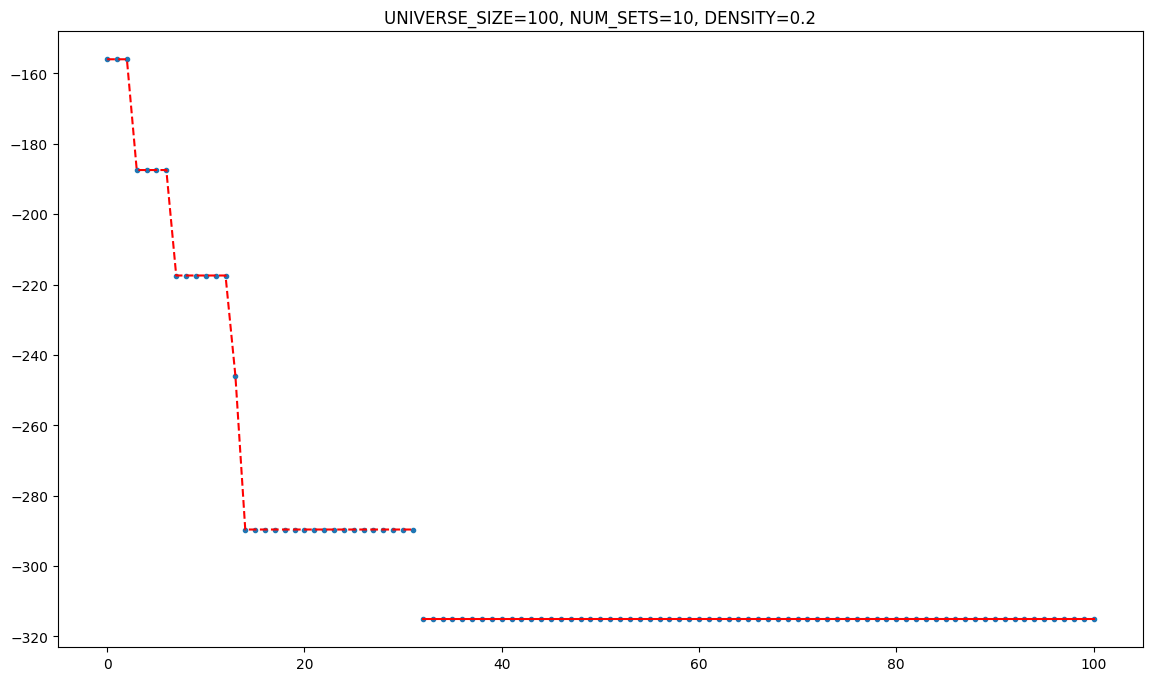

ic| UNIVERSE_SIZE: 1000, NUM_SETS: 100, DENSITY: 0.2, MAX_STEPS: 1000
ic| fitness(solution,elements): (np.int64(1000), np.float64(-15983.90980354502))
    valid(solution): np.True_
100%|██████████| 1000/1000 [00:00<00:00, 17318.60it/s]
ic| fitness(solution,elements): (np.int64(1000), np.float64(-7149.603501489481))
    valid(solution): np.True_


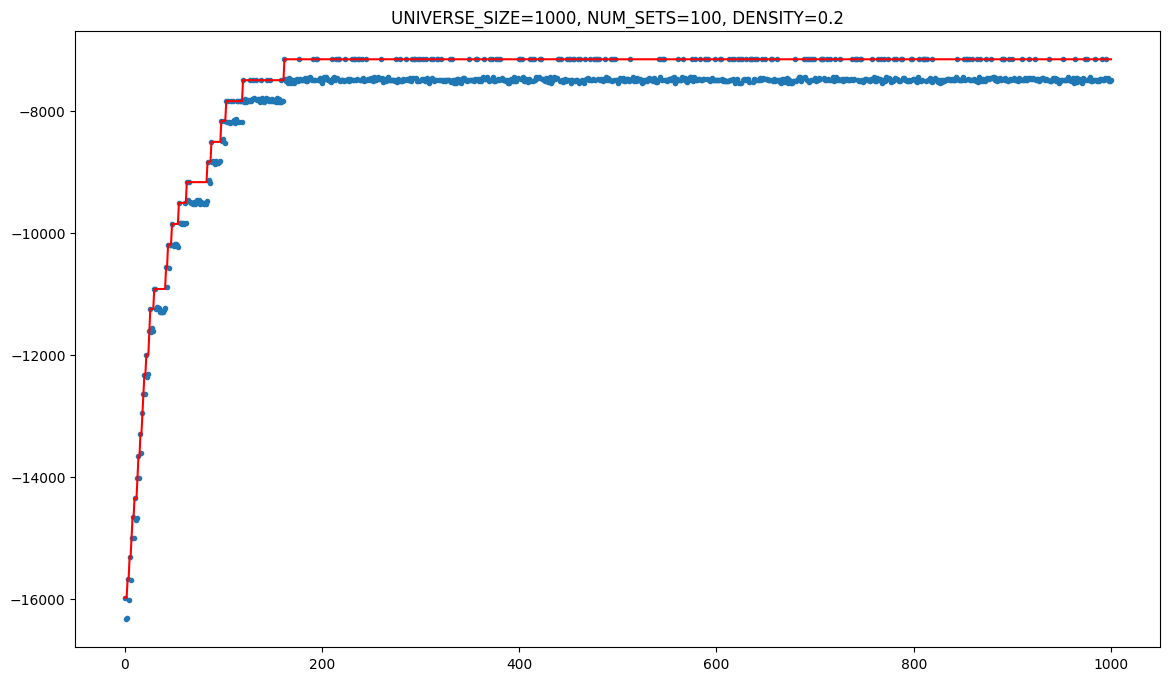

ic| UNIVERSE_SIZE: 10000
    NUM_SETS: 1000
    DENSITY: 0.2
    MAX_STEPS: 10000
ic| fitness(solution,elements): (np.int64(10000), np.float64(-2139027.5076655615))
    valid(solution): np.True_
100%|██████████| 10000/10000 [00:02<00:00, 4724.63it/s]
ic| fitness(solution,elements): (np.int64(10000), np.float64(-132585.19988533243))
    valid(solution): np.True_


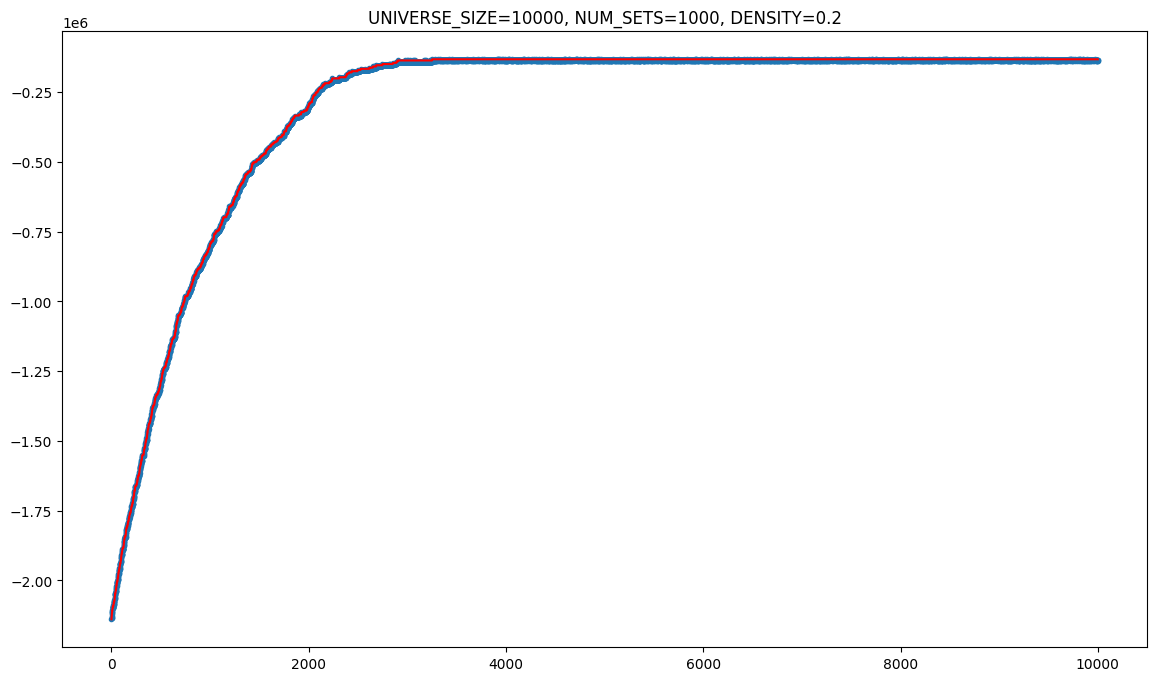

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.1
    MAX_STEPS: 100000
ic| fitness(solution,elements): (np.int64(100000), np.float64(-124554397.00882936))
    valid(solution): np.True_
100%|██████████| 100000/100000 [01:04<00:00, 1550.90it/s]
ic| fitness(solution,elements): (np.int64(100000), np.float64(-1932378.22557172))
    valid(solution): np.True_


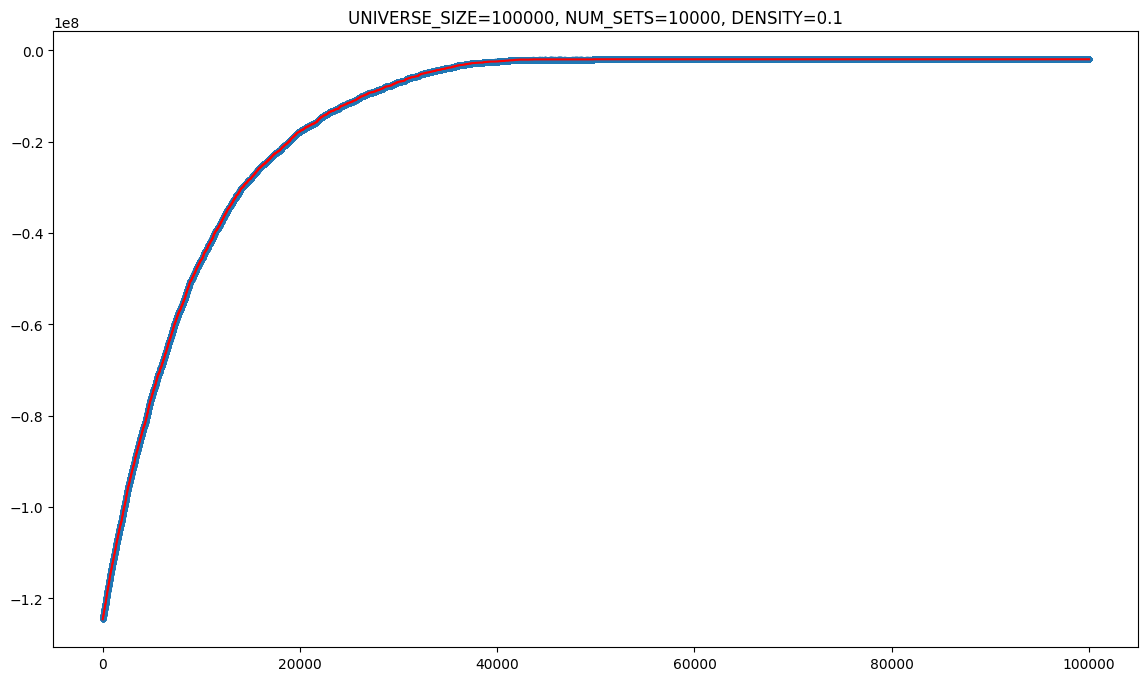

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.2
    MAX_STEPS: 100000
ic| fitness(solution,elements): (np.int64(100000), np.float64(-268464756.2370528))
    valid(solution): np.True_
100%|██████████| 100000/100000 [01:00<00:00, 1666.13it/s]
ic| fitness(solution,elements): (np.int64(100000), np.float64(-2154061.449551455))
    valid(solution): np.True_


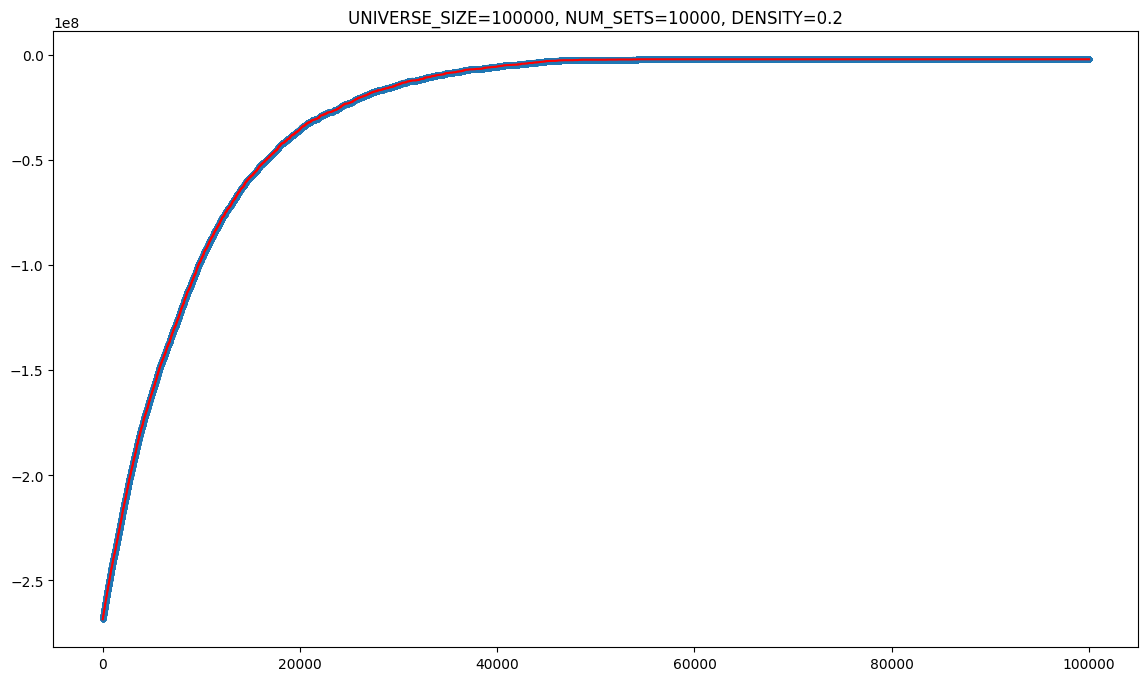

ic| UNIVERSE_SIZE: 100000
    NUM_SETS: 10000
    DENSITY: 0.3
    MAX_STEPS: 100000
ic| fitness(solution,elements): (np.int64(100000), np.float64(-423489851.3958882))
    valid(solution): np.True_
100%|██████████| 100000/100000 [00:59<00:00, 1691.09it/s]
ic| fitness(solution,elements): (np.int64(100000), np.float64(-2186348.3075600723))
    valid(solution): np.True_


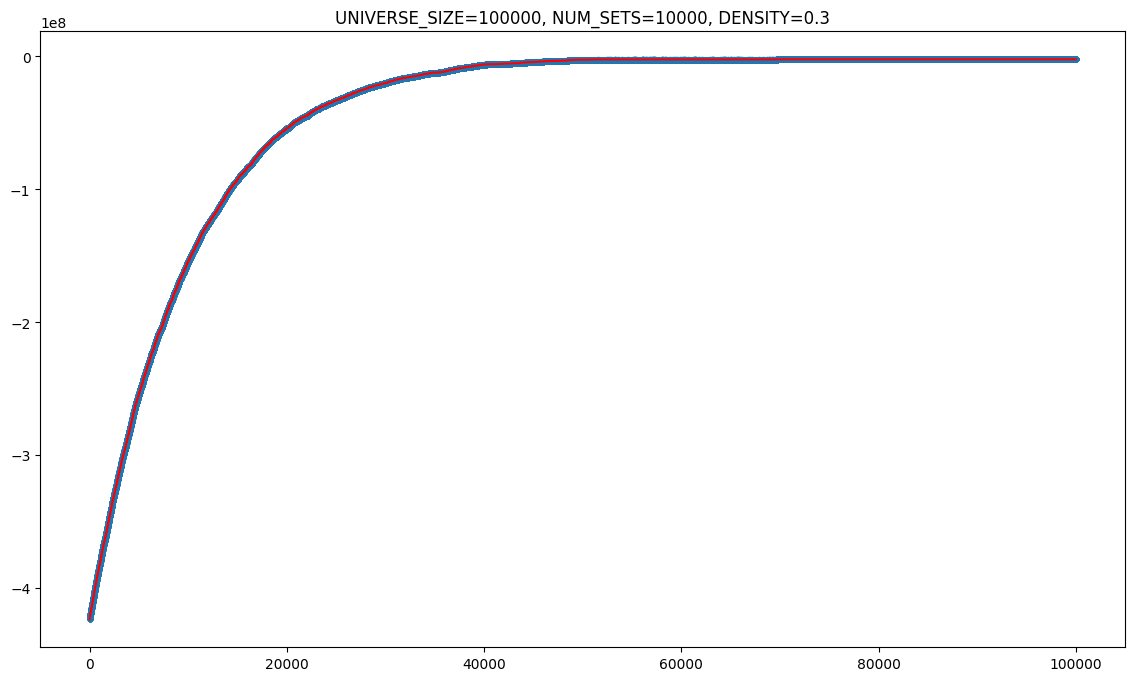

In [128]:
for(UNIVERSE_SIZE, NUM_SETS, DENSITY, MAX_STEPS) in [(100,10,0.2,100),(1000, 100, 0.2, 1000), (10000, 1000, 0.2, 10000), (100000, 10000, 0.1, 100000), (100000, 10000, 0.2, 100000), (100000, 10000, 0.3, 100000)]:
    ic(UNIVERSE_SIZE, NUM_SETS, DENSITY, MAX_STEPS)

    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

    # Generating the sets
    generate_instance()

    # Finding the solution
    solution, history=find_solution(MAX_STEPS)

    # Plotting
    plot_solution(history)

None